In [1]:
# import libraries
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# load the data
df = pd.read_csv('spam.csv')
df.head()

,crl.tot,dollar,bang,money,n000,make,yesno
0,278,0.000,0.778,0.00,0.00,0.00,y
1,1028,0.180,0.372,0.43,0.43,0.21,y
2,2259,0.184,0.276,0.06,1.16,0.06,y
3,191,0.000,0.137,0.00,0.00,0.00,y
4,191,0.000,0.135,0.00,0.00,0.00,y


特征：

- crltot：字数
- dollar：美元符号个数
- bang：惊叹号个数
- money：money单词数量
- n000：000字符的数量
- make：make单词的数量
- yesno：label

In [3]:
# get info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4601 entries, 0 to 4600
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   crl.tot  4601 non-null   int64  
 1   dollar   4601 non-null   float64
 2   bang     4601 non-null   float64
 3   money    4601 non-null   float64
 4   n000     4601 non-null   float64
 5   make     4601 non-null   float64
 6   yesno    4601 non-null   object 
dtypes: float64(5), int64(1), object(1)
memory usage: 251.7+ KB


In [4]:
# statistic info
df.describe()

,crl.tot,dollar,bang,money,n000,make
count,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000
mean,283.289285,0.075811,0.269071,0.094269,0.101645,0.104553
std,606.347851,0.245882,0.815672,0.442636,0.350286,0.305358
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,35.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,95.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,266.000000,0.052000,0.315000,0.000000,0.000000,0.000000
max,15841.000000,6.003000,32.478000,12.500000,5.450000,4.540000


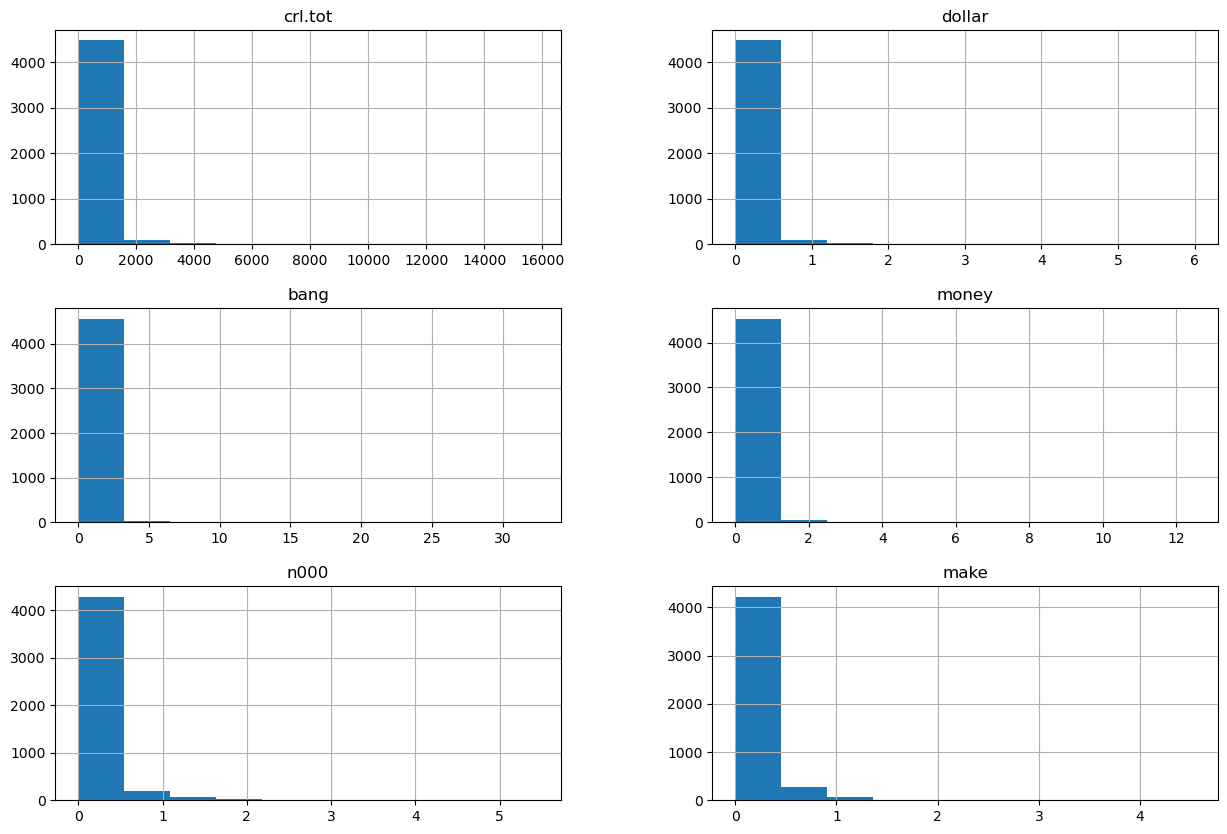

In [5]:
# histgrams
df.hist(figsize=(15, 10))
plt.show()

In [6]:
# remove the outlier
# Removing outliers
print(len(df))
df = df[df['crl.tot'] < 1500]
df = df[df['bang'] < 3]
df = df[df['money'] < 4]
print(len(df))

4601
4412


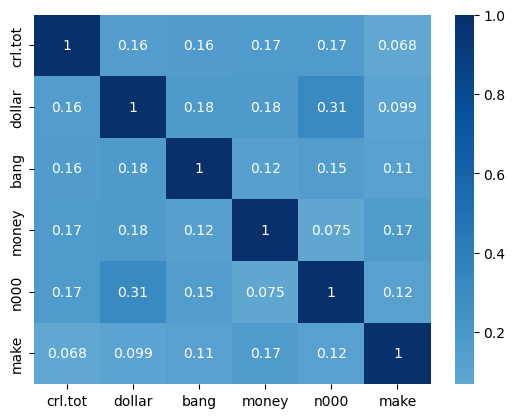

In [10]:
# correlation matrix
sns.heatmap(
    df.corr(numeric_only=True),
    annot = True,
    cmap = 'Blues',
    center = 0
)
plt.show()

In [12]:
# prepare the dependent variable for logistic regression
df['yesno'] = np.where(df['yesno'] == 'y', 1, 0)

In [13]:
# isolate X and y
y = df.yesno
X = df.drop(columns=['yesno'])
X = sm.add_constant(X)

In [14]:
X.head()

,const,crl.tot,dollar,bang,money,n000,make
0,1.0,278,0.00,0.778,0.00,0.00,0.00
1,1.0,1028,0.18,0.372,0.43,0.43,0.21
3,1.0,191,0.00,0.137,0.00,0.00,0.00
4,1.0,191,0.00,0.135,0.00,0.00,0.00
5,1.0,54,0.00,0.000,0.00,0.00,0.00


In [15]:
# train and test split 
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size = 0.2,
    random_state=42
)

In [16]:
# logistic regression
model = sm.Logit(y_train, X_train).fit()
print(model.summary())

Optimization terminated successfully.
         Current function value: 0.391139
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                  yesno   No. Observations:                 3529
Model:                          Logit   Df Residuals:                     3522
Method:                           MLE   Df Model:                            6
Date:                Sun, 10 Mar 2024   Pseudo R-squ.:                  0.4085
Time:                        08:54:07   Log-Likelihood:                -1380.3
converged:                       True   LL-Null:                       -2333.4
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.1970      0.074    -29.815      0.000      -2.341      -2.053
crl.tot        0.0017      0.

In [17]:
# Coefficient Function 
def interpret_logistic_regression(model):
    """
    Interprets the coefficients of a logistic regression model fitted using statsmodels.
    The interpretation is provided in terms of the percentage increase in odds for the event to happen.
    The function automatically detects binary variables and provides information about statistical significance.

    Parameters:
    model : statsmodels.discrete.discrete_model.LogitResultsWrapper
        The fitted logistic regression model.

    Example usage:
        import statsmodels.api as sm
        X = sm.add_constant(data[['feature1', 'feature2']])
        y = data['binary_outcome']
        model = sm.Logit(y, X).fit()
        interpret_logistic_regression(model)
    """
    variables = model.model.exog_names[1:]  # Exclude the constant
    params = model.params[1:]  # Exclude the constant
    pvalues = model.pvalues[1:]  # Exclude the constant

    # Identify binary variables by checking if the min and max of the exogenous variable are 0 and 1
    binary_vars = [var for var, values in zip(variables, model.model.exog[:, 1:].T) if min(values) == 0 and max(values) == 1]

    for variable, coef, pvalue in zip(variables, params, pvalues):
        print('-' * 50)

        # Calculate percentage increase in odds
        percentage_increase = (np.exp(coef) - 1) * 100

        if variable in binary_vars:
            print(f"For the binary variable '{variable}':")
            print(f"  - If this variable changes from 0 to 1, the odds of the event happening increase by {percentage_increase:.2f}%.")
        else:
            print(f"For the continuous variable '{variable}':")
            print(f"  - A unit increase in this variable increases the odds of the event happening by {percentage_increase:.2f}%.")

        # Check for statistical significance
        if pvalue < 0.05:
            print("  - This variable is statistically significant at the 0.05 level.")
        else:
            print("  - This variable is not statistically significant at the 0.05 level.")

    print('-' * 50)

In [18]:
# Apply the function:
interpret_logistic_regression(model)

--------------------------------------------------
For the continuous variable 'crl.tot':
  - A unit increase in this variable increases the odds of the event happening by 0.17%.
  - This variable is statistically significant at the 0.05 level.
--------------------------------------------------
For the continuous variable 'dollar':
  - A unit increase in this variable increases the odds of the event happening by 59868.63%.
  - This variable is statistically significant at the 0.05 level.
--------------------------------------------------
For the continuous variable 'bang':
  - A unit increase in this variable increases the odds of the event happening by 3053.87%.
  - This variable is statistically significant at the 0.05 level.
--------------------------------------------------
For the continuous variable 'money':
  - A unit increase in this variable increases the odds of the event happening by 2482.81%.
  - This variable is statistically significant at the 0.05 level.
----------------

In [20]:
# predictions
predictions = model.predict(X_test)
predictions = np.where(predictions > 0.5, 1, 0)
predictions

array([0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0,
       0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1,
       0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0,
       0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0,
       0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0,

In [21]:
# check if y is imbalanced
y_test.mean()

0.40090600226500567

In [22]:
# confusion matrix
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, predictions)

array([[496,  33],
       [103, 251]])

In [24]:
# classification report
from sklearn.metrics import classification_report
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.83      0.94      0.88       529
           1       0.88      0.71      0.79       354

    accuracy                           0.85       883
   macro avg       0.86      0.82      0.83       883
weighted avg       0.85      0.85      0.84       883



In [25]:
# create a function that computes the 4 KPIs for classification problem
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score

def evaluate_classification_model(y_true, y_pred):
    """
    Evaluates a classification model by computing the accuracy, F1-score, sensitivity, and specificity.

    Parameters:
    y_true : array-like
        True labels of the samples.
    y_pred : array-like
        Predicted labels of the samples.

    Example usage:
        y_true = [1, 0, 1, 1, 0]
        y_pred = [1, 0, 0, 1, 1]
        evaluate_classification_model(y_true, y_pred)
    """

    # Confusion Matrix
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

    # Accuracy
    accuracy = accuracy_score(y_true, y_pred)
    print("Accuracy:")
    print("  - Measures the proportion of correctly classified instances out of the total instances.")
    print(f"  - Result: {accuracy:.2f}\n")

    # F1-Score
    f1 = f1_score(y_true, y_pred)
    print("F1-Score:")
    print("  - Harmonic mean of precision and recall, balances both false positives and false negatives.")
    print(f"  - Result: {f1:.2f}\n")

    # Sensitivity (Recall)
    sensitivity = tp / (tp + fn)
    print("Sensitivity (Recall):")
    print("  - Measures the proportion of actual positives that are correctly identified as such.")
    print(f"  - Result: {sensitivity:.2f}\n")

    # Specificity
    specificity = tn / (tn + fp)
    print("Specificity:")
    print("  - Measures the proportion of actual negatives that are correctly identified as such.")
    print(f"  - Result: {specificity:.2f}\n")

In [26]:
# apply the function
evaluate_classification_model(y_test, predictions)

Accuracy:
  - Measures the proportion of correctly classified instances out of the total instances.
  - Result: 0.85

F1-Score:
  - Harmonic mean of precision and recall, balances both false positives and false negatives.
  - Result: 0.79

Sensitivity (Recall):
  - Measures the proportion of actual positives that are correctly identified as such.
  - Result: 0.71

Specificity:
  - Measures the proportion of actual negatives that are correctly identified as such.
  - Result: 0.94

